# Lab 3: Path planning using the Potential Field Method

# Importing the necessary libraries

In [15]:
# Install required library: scipy
!pip install scipy

In [16]:
# Import necessary Python libraries for numerical operations, plotting, image processing, and gradient computation.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import distance_transform_edt
from scipy.ndimage.filters import sobel

<ipython-input-16-1734688cf80d>:7: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import sobel


# Defining Workspace

In [17]:
# Create an empty binary map of size 180x250 where obstacles will be placed.
map_height, map_width = 180, 250
binary_map = np.zeros((map_height, map_width), dtype=np.uint8)

# Define Obstacles

In [18]:
# Define and draw multiple polygonal obstacles on the binary map.
obstacle1 = np.array([[30, 30], [30, 70], [70, 70], [70, 30]], np.int32)
obstacle2 = np.array([[int(120 + 20 * np.cos(theta)), int(50 + 20 * np.sin(theta))] for theta in np.linspace(0, 2 * np.pi, 20)], np.int32)
obstacle3 = np.array([[200, 40], [230, 20], [240, 60]], np.int32)
obstacle4 = np.array([[180, 150], [210, 130], [230, 160], [200, 180], [170, 160]], np.int32)
obstacle5 = np.array([[90, 120], [110, 120], [110, 140], [130, 140], [130, 160], [90, 160]], np.int32)

for obs in [obstacle1, obstacle2, obstacle3, obstacle4, obstacle5]:
    cv2.fillPoly(binary_map, [obs], 1)

# Visualize Obstacles

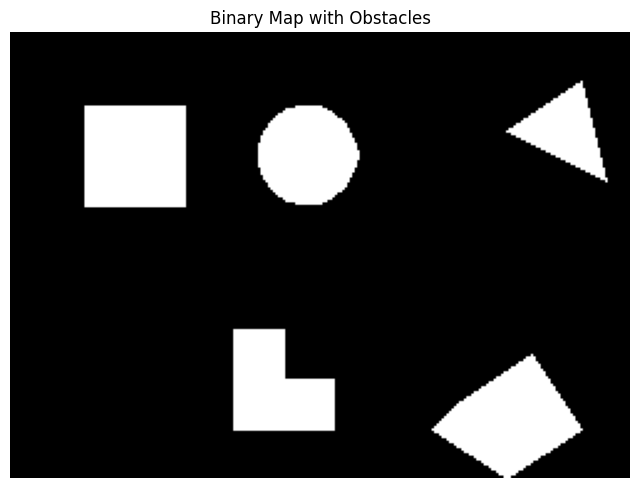

In [19]:
# Visualize the binary map to confirm obstacle placement.
plt.figure(figsize=(8, 6))
plt.imshow(binary_map, cmap='gray')
plt.title('Binary Map with Obstacles')
plt.axis('off')
plt.show()

## Define Start, Goal, and Potential Field Parameters

In [20]:
# Initialize parameters for attractive and repulsive potential fields, step size, and path planning thresholds.
start = np.array([25.0, 25.0])
goal = np.array([100.0, 170.0])
k_att = 3
k_rep = 60
repulsive_radius = 15.0
step_size = 0.7
max_iters = 20000
goal_threshold = 2.0

## Define Helper Functions

In [21]:
# Define utility functions to check for map boundaries, obstacle collisions, and compute attractive force toward goal.
def is_in_bounds(pos):
    x, y = int(round(pos[0])), int(round(pos[1]))
    return 0 <= x < map_height and 0 <= y < map_width

def is_collision(pos):
    x, y = int(round(pos[0])), int(round(pos[1]))
    if not is_in_bounds(pos):
        return True
    return binary_map[x, y] == 1

def attractive_force(pos):
    vec = goal - pos
    return k_att * vec / (np.linalg.norm(vec) + 1e-6)

## Compute Distance Map and Repulsive Gradient

In [22]:
# Compute distance transform from obstacles and gradients using Sobel filter for repulsive force computation.
obstacle_mask = binary_map == 1
distance_map = distance_transform_edt(~obstacle_mask)
grad_x = sobel(distance_map, axis=0)
grad_y = sobel(distance_map, axis=1)

## Repulsive Force Calculation

In [23]:
# Calculate the repulsive force at a point based on obstacle distance and gradient direction.
def repulsive_force(pos):
    x, y = int(round(pos[0])), int(round(pos[1]))
    if not is_in_bounds(pos):
        return np.zeros(2)
    dist = distance_map[x, y]
    if dist > repulsive_radius or dist <= 1e-2:
        return np.zeros(2)
    grad = np.array([grad_x[x, y], grad_y[x, y]])
    grad_norm = np.linalg.norm(grad)
    if grad_norm == 0:
        return np.zeros(2)
    factor = k_rep * (1.0 / dist - 1.0 / repulsive_radius) / (dist ** 2)
    return factor * (grad / grad_norm)

## Generate and Plot Potential Fields

In [24]:
# Compute full potential fields: attractive, repulsive, and total field maps.
def compute_repulsive_field(grid_shape):
    field = np.zeros(grid_shape, dtype=np.float32)
    for x in range(grid_shape[0]):
        for y in range(grid_shape[1]):
            pos = np.array([x, y], dtype=np.float32)
            rep_val = 0.0
            if binary_map[x, y] == 1:
                rep_val = np.inf
            else:
                for dx in range(-int(repulsive_radius), int(repulsive_radius) + 1):
                    for dy in range(-int(repulsive_radius), int(repulsive_radius) + 1):
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < binary_map.shape[0] and 0 <= ny < binary_map.shape[1]:
                            if binary_map[nx, ny] == 1:
                                vec = pos - np.array([nx, ny])
                                dist = np.linalg.norm(vec)
                                if dist < repulsive_radius and dist > 1e-5:
                                    rep_val += 0.5 * k_rep * (1.0 / dist - 1.0 / repulsive_radius) ** 2
            field[x, y] = min(rep_val, 1000)
    return field

attrac_field_map = np.zeros((map_height, map_width))
for x in range(map_height):
    for y in range(map_width):
        attrac_field_map[x, y] = np.linalg.norm(goal - np.array([x, y])) * k_att

repul_field_map = compute_repulsive_field((map_height, map_width))
total_field_map = attrac_field_map + repul_field_map

# Visualize Plot Potential Fields

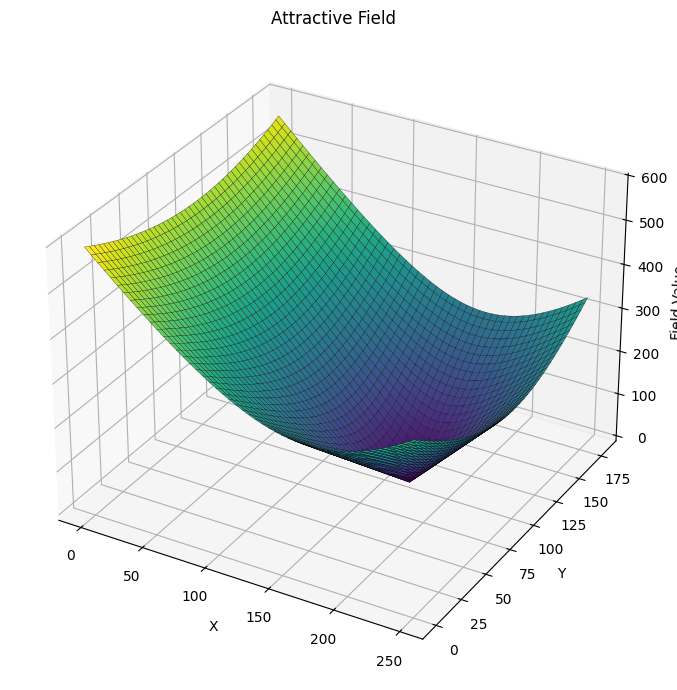

In [25]:
# Plot 3D surface plots of the potential fields to visualize terrain structure.
def plot_3d_field(field, title="3D Field"):
    x = np.arange(field.shape[1])
    y = np.arange(field.shape[0])
    X, Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, field, cmap='viridis', edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Field Value")
    plt.tight_layout()
    plt.show()

plot_3d_field(attrac_field_map, 'Attractive Field')


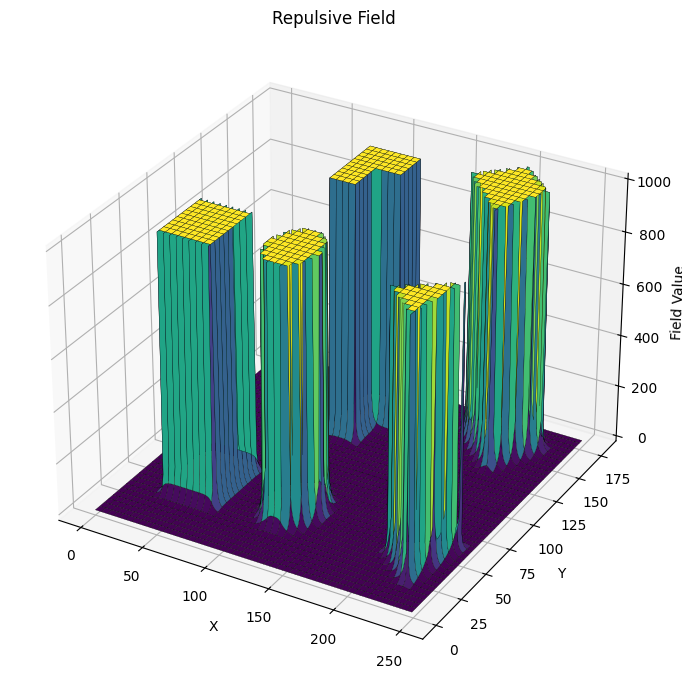

In [26]:
plot_3d_field(repul_field_map, 'Repulsive Field')

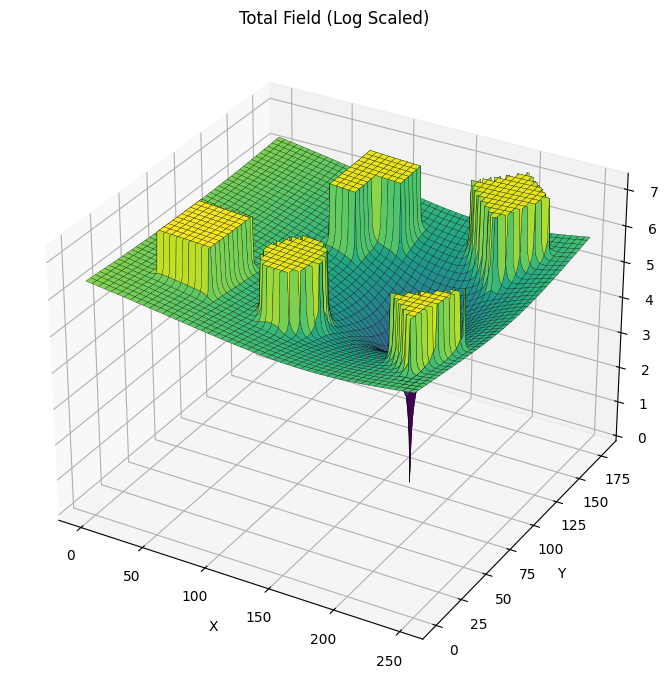

In [27]:
plot_3d_field(np.log(total_field_map + 1), 'Total Field (Log Scaled)')

## Visualize Vector Fields

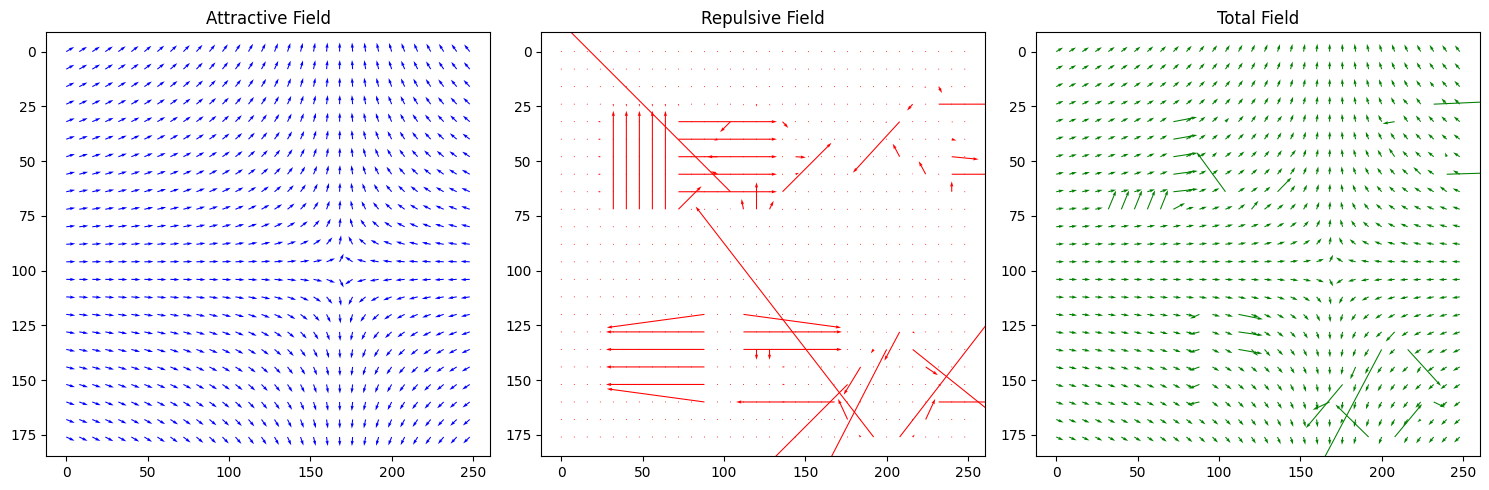

In [28]:
# Display vector fields for attractive, repulsive, and total forces.
skip = 8
X, Y = np.meshgrid(np.arange(0, map_width, skip), np.arange(0, map_height, skip))
U_att, V_att = np.zeros_like(X, dtype=float), np.zeros_like(Y, dtype=float)
U_rep, V_rep = np.zeros_like(X, dtype=float), np.zeros_like(Y, dtype=float)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        p = np.array([Y[i, j], X[i, j]])
        a = attractive_force(p)
        r = repulsive_force(p)
        U_att[i, j], V_att[i, j] = a[1], a[0]
        U_rep[i, j], V_rep[i, j] = r[1], r[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.quiver(X, Y, U_att, V_att, color='blue')
plt.title("Attractive Field")
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
plt.quiver(X, Y, U_rep, V_rep, color='red')
plt.title("Repulsive Field")
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
plt.quiver(X, Y, U_att + U_rep, V_att + V_rep, color='green')
plt.title("Total Field")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Path Planning Using Potential Fields

In [29]:
# Define and execute path planning algorithm based on computed potential field forces.
def follow_potential_field():
    pos = start.copy()
    path = [pos.copy()]
    stuck_counter = 0
    max_stuck_steps = 100
    min_movement = 1e-3
    momentum = np.zeros(2)

    for i in range(max_iters):
        f_att = attractive_force(pos)
        f_rep = repulsive_force(pos)
        total_force = f_att + f_rep
        dist_to_goal = np.linalg.norm(pos - goal)
        if dist_to_goal < goal_threshold:
            path.append(goal.copy())
            print("Goal reached!")
            break

        norm = np.linalg.norm(total_force)
        if norm < 1e-8:
            total_force = f_att

        direction = total_force / (np.linalg.norm(total_force) + 1e-6)
        momentum = 0.8 * momentum + 0.2 * direction
        momentum /= np.linalg.norm(momentum) + 1e-6

        step = step_size
        if dist_to_goal < 10:
            step = min(step_size * 2, dist_to_goal)

        new_pos = pos + step * momentum
        if is_collision(new_pos):
            perp1 = np.array([-momentum[1], momentum[0]])
            perp2 = np.array([momentum[1], -momentum[0]])
            options = [new_pos + step * perp1, new_pos + step * perp2]
            moved = False
            for opt in options:
                if not is_collision(opt):
                    pos = opt
                    moved = True
                    break
            if not moved:
                pos += np.random.uniform(-1.5, 1.5, size=2)
        else:
            pos = new_pos

        if len(path) > 5 and np.linalg.norm(pos - path[-1]) < min_movement:
            stuck_counter += 1
        else:
            stuck_counter = 0

        if stuck_counter > max_stuck_steps:
            print(f"Stuck too long, escaping at step {i}")
            direction_to_goal = goal - pos
            direction_to_goal /= np.linalg.norm(direction_to_goal) + 1e-8
            pos += step_size * 4 * direction_to_goal
            stuck_counter = 0

        path.append(pos.copy())

    return np.array(path)

path = follow_potential_field()

Goal reached!


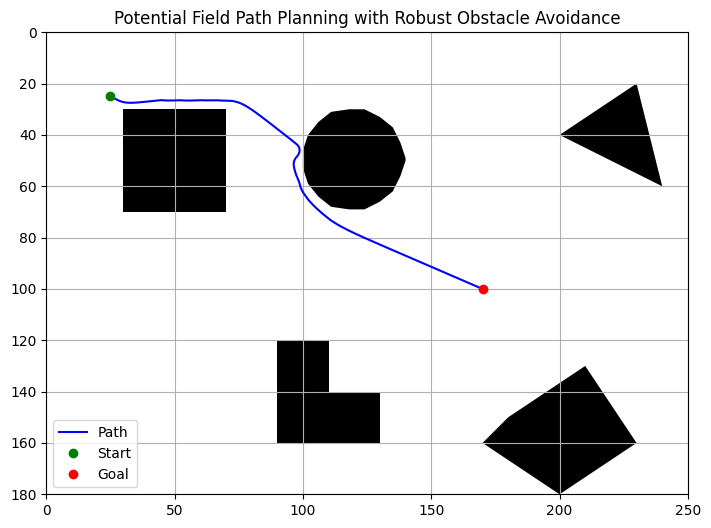

In [30]:
# Plot the computed path along with the obstacles, start, and goal positions.
fig, ax = plt.subplots(figsize=(10, 6))
for obs in [obstacle1, obstacle2, obstacle3, obstacle4, obstacle5]:
    polygon = patches.Polygon(obs, closed=True, facecolor='black')
    ax.add_patch(polygon)

ax.plot(path[:, 1], path[:, 0], 'b-', label='Path')
ax.plot(start[1], start[0], 'go', label='Start')
ax.plot(goal[1], goal[0], 'ro', label='Goal')

ax.set_xlim(0, map_width)
ax.set_ylim(map_height, 0)
ax.set_aspect('equal')
ax.legend()
ax.grid(True)
plt.title("Potential Field Path Planning with Robust Obstacle Avoidance")
plt.show()

## Conclusion
In this notebook, we implemented a **Potential Field-based Path Planning** algorithm in a 2D environment.
- We modeled the environment with multiple obstacles.
- Attractive and repulsive potential fields were computed and visualized.
- A path-following strategy was designed using these forces, with enhancements to avoid local minima.
- The final path demonstrates successful navigation from start to goal, effectively avoiding obstacles.

**This approach is efficient and computationally inexpensive, but may require enhancements to handle complex local minima in real-world applications.**